In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import corner

from astropy.time import Time
from astropy import time, coordinates as coord, units as u
import astropy.constants as c

import time as timer

tangerine = ['#1a2754','#f9a919','#2ab59f','#e2721c','#db3e0e','#067bc1']

In [2]:
def normalize_lc(flux):
    #Returns median-normalized flux in units of parts-per-thousand
    mu = np.nanmedian(flux)
    return (flux/mu - 1) * 1e3

# **K2 light curve**

In [3]:
from astropy.io import fits
from scipy.signal import savgol_filter

lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c04/210800000/18897/hlsp_everest_k2_llc_210818897-c04_kepler_v2.0_lc.fits"
    
# Download the data
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
ktwo_texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
ktwo_texp /= 60.0 * 60.0 * 24.0

ktwo_x = lc["TIME"]
ktwo_y = lc["FLUX"]
ktwo_qual = lc["QUALITY"]    
    
# Mask bad data
m = np.isfinite(ktwo_x) & np.isfinite(ktwo_y)

# Median normalize flux and convert to parts per thousand
ktwo_y = normalize_lc(ktwo_y)
ktwo_yerr = 0.177*np.ones_like(ktwo_y)


# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(ktwo_x[m])

# Trim the light curve around the transit of planet e
m &= (abs(ktwo_x-2263.6229)<0.5)

# Make sure that the data type is consistent
ktwo_x = np.ascontiguousarray(ktwo_x[m], dtype=np.float64)
ktwo_y = np.ascontiguousarray(ktwo_y[m], dtype=np.float64)
ktwo_yerr = np.ascontiguousarray(ktwo_yerr[m], dtype=np.float64)
ktwo_qual = np.ascontiguousarray(ktwo_qual[m], dtype=np.float64)

print('XREF =', x_ref)

XREF = 2228.800412053417


In [4]:
#Note: upload the TICA light curve from the file manager at left
tica = np.loadtxt('../data/v1298_s43_o1_v2.txt')
tess_mjd  = tica[:,0] 
tess_f1   = tica[:,1]

tess_f1 = normalize_lc(tess_f1)


tess_bjd  = Time(tess_mjd, format='mjd').jd

# light travel time correction
greenwich = coord.EarthLocation.of_site('greenwich')
times = time.Time(tess_bjd, format='jd', location=greenwich)
moon = coord.get_moon(times)
delta_time = times.light_travel_time(moon)
tess_bkjd = times.value + delta_time.value - 2454833.0

tess_beg = tess_bkjd.min()
tess_end = tess_bkjd.max()
tess_mission_flag = ['tess']*len(tess_bkjd)
tess_texp = np.median(np.diff(tess_bkjd))
print(tess_texp)

tess_x = tess_bkjd
tess_y = tess_f1

# Select the data around the transit of planet e (we think)
tess_m = abs(tess_x-4648.8)<0.5

tess_x = np.ascontiguousarray(tess_x[tess_m], dtype=np.float64)
tess_y = np.ascontiguousarray(tess_y[tess_m], dtype=np.float64)

#mission_flag = tess_mission_flag

0.006944432854652405


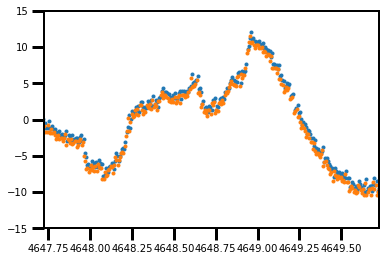

In [8]:
tica2 = np.loadtxt('../data/v1298_s43_o1_v2.txt')

tica2_mjd  = tica2[:,0] 
tica2_bjd  = Time(tica2_mjd, format='mjd').jd
tica2_bkjd = tica2_bjd - 2454833.0


tica2_f1   = normalize_lc(tica2[:,1])
tica2_f2   = normalize_lc(tica2[:,2])

plt.plot(tess_bkjd, tess_f1+0.5, '.')
plt.plot(tica2_bkjd, tica2_f1, '.')
#plt.xlim(4645.39920514-0.5,4645.39920514+0.5)
plt.xlim(4648.72281079-1, 4648.72281079+1)
#plt.ylim(-5,10)
plt.ylim(-15,15)
plt.show()

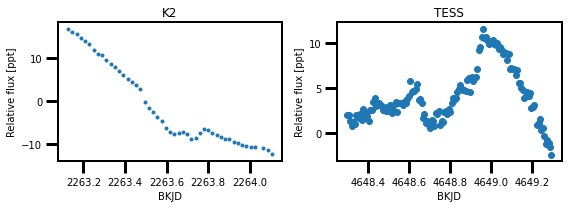

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

# Plot the data
ax1.errorbar(ktwo_x, ktwo_y, yerr=ktwo_yerr, fmt='.', label="K2")
ax1.set_xlabel("BKJD")
ax1.set_ylabel("Relative flux [ppt]")
ax1.set_title("K2")

ax2.scatter(tess_x, tess_y)
ax2.set_xlabel("BKJD")
ax2.set_ylabel("Relative flux [ppt]")
ax2.set_title("TESS")

plt.tight_layout()
plt.show()

In [ ]:
#Stellar parameters
M_star  = 1.10, 0.05
R_star  = 1.305, 0.07

n_pl = 1

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

def build_model(ktwo_mask=None, 
                tess_mask=None, 
                start=None,
                eccentric=False):
    
    if ktwo_mask is None:
        ktwo_mask = np.ones(len(ktwo_x), dtype=bool)
    if tess_mask is None:
        tess_mask = np.ones(len(tess_x), dtype=bool)
    
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        
        # K2 transit depth and radius ratio
        log_depth_ktwo = pm.Normal("log_depth_ktwo", mu=np.log(4), sigma=2)                        
        ror_ktwo = pm.Deterministic("ror_ktwo", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth_ktwo), b
                                    ),
                                   )
        r_pl_ktwo = pm.Deterministic("r_pl_ktwo", ror_ktwo * r_star)
        r_pl_rade_ktwo = pm.Deterministic("r_pl_rade_ktwo", ror_ktwo * r_star * c.R_sun/c.R_earth)

        # Eccentricity and longitude of periastron
        if eccentric==True:
            ecs = pmx.UnitDisk("ecs", shape=(2, 1), testval=0.01 * np.ones((2, 1)))
            ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
            omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
            xo.eccentricity.vaneylen19("ecc_prior", 
                                        multi=True, shape=1, fixed=True, observed=ecc)
        
        elif eccentric==False:
            ecc = np.zeros(n_pl)
            omega = np.pi/2*np.ones(n_pl)
            
        
        # Ephemeris parameters
        t0 = pm.Normal("t0", mu=2263.6229, sd=0.1)
        log_period = pm.Normal("log_period", mu=np.log(48.67687959183674), sd=1e-5)
        #log_period = pm.Normal("log_period", mu=np.log(48.67687959183674), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Orbit models
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        ########################################################################################        
        ########################################################################################
        # Compute the model light curve
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)
        mean_ktwo = pm.Normal("mean_ktwo", mu=0.0, sd=10.0)

        light_curves_ktwo = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_ktwo, 
                t=ktwo_x[ktwo_mask], 
                texp=ktwo_texp) * 1e3
        )
        light_curve_ktwo = pm.math.sum(light_curves_ktwo, axis=-1) + mean_ktwo

        
        light_curves_tess = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_ktwo, 
                t=tess_x[tess_mask], 
                texp=tess_texp) * 1e3
        )
        light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess

        
        # Light curve noise and in-transit jitter
        log_sigma_lc_ktwo  = pm.Normal("log_sigma_lc_ktwo", mu=np.log(0.01*np.std(ktwo_y[ktwo_mask])), sd=10)
        log_sigma_jit_ktwo = pm.Normal("log_sigma_jit_ktwo", mu=np.log(0.02*np.std(ktwo_y[ktwo_mask])), sd=10) 
        yerr_ktwo = pm.Deterministic("yerr_ktwo", tt.exp(log_sigma_lc_ktwo) + tt.exp(2*log_sigma_jit_ktwo)*(light_curve_ktwo**2))
        
        
        # Light curve noise and in-transit jitter
        log_sigma_lc_tess  = pm.Normal("log_sigma_lc_tess", mu=np.log(0.01*np.std(tess_y[tess_mask])), sd=10)
        log_sigma_jit_tess = pm.Normal("log_sigma_jit_tess", mu=np.log(0.02*np.std(tess_y[tess_mask])), sd=10) 
        yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess) + tt.exp(2*log_sigma_jit_tess)*(light_curve_tess**2))

        resid_tess = pm.Deterministic("resid_tess", tess_y[tess_mask] - light_curve_tess)
        resid_ktwo = pm.Deterministic("resid_ktwo", ktwo_y[ktwo_mask] - light_curve_ktwo)

        #The parameters of the first SHO term
        log_rho_sho_ktwo = pm.Normal("log_rho_sho_ktwo", mu=0.0, sd=10)
        log_sigma_sho_ktwo = pm.Normal("log_sigma_sho_ktwo", mu=np.log(np.std(ktwo_y[ktwo_mask])), sd=10)

        #The parameters of the first SHO term
        log_rho_sho_tess = pm.Normal("log_rho_sho_tess", mu=0.0, sd=10)
        log_sigma_sho_tess = pm.Normal("log_sigma_sho_tess", mu=np.log(np.std(tess_y[tess_mask])), sd=10)


        kernel_ktwo = terms.SHOTerm(
            sigma=tt.exp(log_sigma_sho_ktwo),
            rho=tt.exp(log_rho_sho_ktwo),
            Q=1 / np.sqrt(2),
        )

        kernel_tess = terms.SHOTerm(
            sigma=tt.exp(log_sigma_sho_tess),
            rho=tt.exp(log_rho_sho_tess),
            Q=1 / np.sqrt(2),
        )        

        gp_ktwo = GaussianProcess(kernel_ktwo, t=ktwo_x[ktwo_mask], yerr=yerr_ktwo)
        gp_ktwo.marginal("transit_obs_ktwo", observed=resid_ktwo)

        gp_tess = GaussianProcess(kernel_tess, t=tess_x[tess_mask], yerr=yerr_tess)
        gp_tess.marginal("transit_obs_tess", observed=resid_tess)           

        map_soln = model.test_point
        
        map_soln = pmx.optimize(start=map_soln, vars=[log_rho_sho_ktwo, log_sigma_sho_ktwo,
                                                   log_rho_sho_tess, log_sigma_sho_tess,
                                                   mean_ktwo, mean_tess
                                                   ])

        map_soln = pmx.optimize(start=map_soln, vars=[b, log_depth_ktwo])

        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves_ktwo",
                 "light_curves_tess",
                 "gp_pred_ktwo",
                 "gp_pred_tess"],
                pmx.eval_in_model([light_curves_ktwo,
                                   light_curves_tess,
                                   gp_ktwo.predict(resid_ktwo),
                                   gp_tess.predict(resid_tess)], 
                                   map_soln),
            )
        )

    return model, map_soln, extras, orbit

model0, map_soln0, extras0, orbit0 = build_model()

In [ ]:
def plot_light_curve(soln, 
                     extras, 
                     xrange=[4641,4653], 
                     ktwo_mask=None,
                     tess_mask=None):

    
    if ktwo_mask is None:
        ktwo_mask = np.ones(len(ktwo_x), dtype=bool)

    if tess_mask is None:
        tess_mask = np.ones(len(tess_x), dtype=bool)        
        
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

    gp_mod_ktwo = extras["gp_pred_ktwo"] + soln["mean_ktwo"]
    gp_mod_tess = extras["gp_pred_tess"] + soln["mean_tess"]

    mod_sum_ktwo = np.sum(extras["light_curves_ktwo"], axis=-1)
    mod_sum_tess = np.sum(extras["light_curves_tess"], axis=-1)

    mod_ktwo = gp_mod_ktwo + mod_sum_ktwo
    mod_ktwo = gp_mod_tess + mod_sum_tess

    xdata = [ktwo_x[ktwo_mask], tess_x[tess_mask]]
    ydata = [ktwo_y[ktwo_mask], tess_y[tess_mask]]
    mission = ["ktwo", "tess"]

    for i in range(2):

    gp_mod = extras["gp_pred_"+mission[i]] + soln["mean_"+mission[i]]
    lc_mod = np.sum(extras["light_curves_"+mission[i]], axis=-1)

    yerr = soln["yerr_"+mission[i]]

    ax = axes[0][i]
    ax.errorbar(xdata[i], ydata[i], yerr=yerr, **ebar_kws) 
    ax.plot(xdata[i], gp_mod, color="C2", label="GP model")
    ax.legend(fontsize=10)
    ax.set_ylabel("Relative flux [ppt]")
    ax.set_title(mission[i].upper())

    ax = axes[1][i]
    ax.errorbar(xdata[i], ydata[i] - gp_mod, yerr=yerr,  **ebar_kws)
    ax.plot(xdata[i], lc_mod, label="Transit model", color="C5")          
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("De-trended flux [ppt]")
    ax.set_ylim(-7.5,3.5)

    ax = axes[2][i]
    ax.errorbar(xdata[i], ydata[i] - gp_mod - lc_mod, yerr=yerr,  **ebar_kws)
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("Residuals [ppt]")
    ax.set_xlabel("BKJD [days]")

    plt.tight_layout()

    return fig
 
_ = plot_light_curve(map_soln0, extras0)

In [ ]:
ktwo_ydet = ktwo_y - extras0["gp_pred_ktwo"] - map_soln0["mean_ktwo"]
tess_ydet = tess_y - extras0["gp_pred_tess"] - map_soln0["mean_tess"]

ktwo_yerr = map_soln0["yerr_ktwo"]
tess_yerr = map_soln0["yerr_tess"]

ktwo_fold = (ktwo_x - map_soln0["t0"] + 0.5 * map_soln0["period"]) % map_soln0["period"] - 0.5*map_soln0["period"]
tess_fold = (tess_x - map_soln0["t0"] + 0.5 * map_soln0["period"]) % map_soln0["period"] - 0.5*map_soln0["period"]

plt.errorbar(24*tess_fold, tess_ydet, yerr=tess_yerr, fmt="o", label='TESS')
plt.errorbar(24*ktwo_fold, ktwo_ydet, yerr=ktwo_yerr, fmt="o", label='K2')
plt.legend()
plt.xlim(-12,12)
plt.xlabel('Time from mid-transit [hours]')
plt.ylabel('De-trended flux [ppt]')
plt.gcf().set_size_inches(7,4)
plt.show()

# What are the possible periods for planet e? 
In the discovery paper we ruled out periods <36 days based on the fact that we didn't observe any additional transits of ~0.5% depth in the light curve. I'm **pretty sure** I'd stick by that statement! :) 

So if n is the number of transits between K2 and TESS we have a discrete set of possible periods, where we only need to consider n in the range of 1 to some number that maxes out when the implied period becomes less than 36 d

In [10]:
for n in range(1, 70): 
    print(n, (4648.79  - 2263.6229)/n)

1 2385.1671
2 1192.58355
3 795.0557
4 596.291775
5 477.03342000000004
6 397.52785
7 340.7381571428572
8 298.1458875
9 265.0185666666667
10 238.51671000000002
11 216.83337272727275
12 198.763925
13 183.4743923076923
14 170.3690785714286
15 159.01114
16 149.07294375
17 140.30394705882352
18 132.50928333333334
19 125.53511052631579
20 119.25835500000001
21 113.57938571428572
22 108.41668636363637
23 103.70291739130435
24 99.3819625
25 95.406684
26 91.73719615384616
27 88.33952222222223
28 85.1845392857143
29 82.24714137931035
30 79.50557
31 76.9408741935484
32 74.536471875
33 72.27779090909091
34 70.15197352941176
35 68.14763142857143
36 66.25464166666667
37 64.46397567567568
38 62.767555263157895
39 61.15813076923077
40 59.629177500000004
41 58.174807317073174
42 56.78969285714286
43 55.4690023255814
44 54.20834318181819
45 53.00371333333334
46 51.85145869565218
47 50.74823617021277
48 49.69098125
49 48.67687959183674
50 47.703342
51 46.76798235294118
52 45.86859807692308
53 45.003152830

# **Discrete period model**


In [ ]:
#Stellar parameters
M_star  = 1.10, 0.05
R_star  = 1.305, 0.07

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

def discrete_period_model(ktwo_mask=None, 
                          tess_mask=None, 
                          start=None,
                          eccentric=False):
    
    if ktwo_mask is None:
        ktwo_mask = np.ones(len(ktwo_x), dtype=bool)
    if tess_mask is None:
        tess_mask = np.ones(len(tess_x), dtype=bool)
    
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        
        # Assume a constant transit depth and radius ratio between K2 and TESS
        log_depth = pm.Normal("log_depth", mu=np.log(5), sigma=1)                        
        ror = pm.Deterministic("ror", 
                               star.get_ror_from_approx_transit_depth(
                                   1e-3 * tt.exp(log_depth), b
                                    ),
                                   )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        r_pl_rade = pm.Deterministic("r_pl_rade", ror * r_star * c.R_sun/c.R_earth)


        # Eccentricity and longitude of periastron
        if eccentric==True:
            ecs = pmx.UnitDisk("ecs", shape=(2, 1), testval=0.01 * np.ones((2, 1)))
            ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
            omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
            xo.eccentricity.vaneylen19("ecc_prior", 
                                    multi=True, shape=1, fixed=True, observed=ecc)
        
        elif eccentric==False:
            ecc = 0
            omega = np.pi/2
        
        # K2 transit midpoint
        t0 = pm.Normal("t0", mu=2263.6229, sigma=0.1)
        # TESS transit midpoint
        tn = pm.Normal("tn", mu=4648.79, sigma=0.1)

        logls = []
        
        #Note: if we want to explore longer periods we need to decrease the lower end of this range!
        for n in range(38,56): 
        
          period = pm.Deterministic(f"period_{n}", (tn - t0) / n)

          # Orbit models
          orbit = xo.orbits.KeplerianOrbit(
              r_star=r_star,
              m_star=m_star,
              period=period,
              t0=t0,
              b=b,
              ecc=ecc,
              omega=omega,
              )
    
          # Compute light curve
          # Since we are dealing with the flattened light curve we can eliminate the mean for now, but we may want to add this back in
          # mean_ktwo = pm.Normal("mean_ktwo", mu=0.0, sd=10.0) 
          # mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)

            light_curves_ktwo = (
              star.get_light_curve(
                  orbit=orbit, 
                  r=r_pl, 
                  t=ktwo_x[ktwo_mask], 
                  texp=ktwo_texp) * 1e3
          )
            
            light_curve_ktwo = pm.math.sum(light_curves_ktwo, axis=-1) #+ mean_ktwo

            light_curves_tess = (
              star.get_light_curve(
                  orbit=orbit, 
                  r=r_pl, 
                  t=tess_x[tess_mask], 
                  texp=tess_texp) * 1e3
          )
            light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) #+ mean_tess

            logln_ktwo = pm.Normal.dist(mu=light_curve_ktwo, sigma=np.max(ktwo_yerr)).logp(ktwo_ydet)
            logln_tess = pm.Normal.dist(mu=light_curve_tess, sigma=np.max(tess_yerr)).logp(tess_ydet)

            logln = tt.sum(logln_ktwo) + tt.sum(logln_tess)

            pm.Deterministic(f"logl_{n}", logln)
            logls.append(logln)


        logl = tt.log(tt.sum(tt.exp(tt.stack(logls))))

        # print(model.fastfn(logl)(model.test_point))

        pm.Deterministic("logl", logl)
        pm.Potential("obs", logl)

        # # Fit for the maximum a posteriori parameters, I've found that I can get
        # # a better solution by trying different combinations of parameters in turn
        map_soln = model.test_point

        map_soln = pmx.optimize(start=map_soln)


        # Plot the MAP solution
        fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
        
        ax1.errorbar(ktwo_x[ktwo_mask], ktwo_ydet[ktwo_mask], yerr=np.max(ktwo_yerr), fmt='o')
        ax1.plot(ktwo_x[ktwo_mask], pmx.eval_in_model(light_curve_ktwo, map_soln))

        ax2.errorbar(tess_x[tess_mask], tess_ydet[tess_mask], yerr=np.max(tess_yerr), fmt='o')
        ax2.plot(tess_x, pmx.eval_in_model(light_curve_tess, map_soln))

        for ax in [ax1,ax2]:
            ax.set_xlabel('Time [BKJD]')
            ax.set_ylabel('De-trended flux [ppt]')

        plt.tight_layout()
        plt.show()


    return model, map_soln, orbit

model, map_soln, orbit = discrete_period_model()

In [ ]:
random_seeds = [134907314, 81924949, 101834041]
for i in range(0,len(random_seeds)):
    with model:
        trace = pmx.sample(tune=500,
                            draws=5000,
                            start=map_soln,
                            chains=1,
                            cores=3,
                            return_inferencedata=True,
                            random_seed=[random_seeds[i]])
    az.summary(trace).to_csv('trace_planete{0}.csv'.format(i))

In [ ]:
az.summary(trace).to_csv('trace0.csv')

In [ ]:
period = np.stack([trace[f"period_{n}"] for n in range(44, 56)], axis=-1)
logw = np.stack([trace[f"logl_{n}"] - trace["logl"] for n in range(44, 56)], axis=-1)
plt.hist(period.flatten(), 100, weights=np.exp(logw.flatten()), density=True);

#Let's plot where the resonances with planet b are
period_b = 24.141445
#for res in [3/2, 5/3, 2, 3]:
#  plt.axvline(res*period_b, lw=4, alpha=0.2, color='C1')
#  plt.text(res*period_b, 0.1, "Pe/Pb = "+f"{np.round(res,2)}", rotation=90, size=10)
plt.xlabel('Period [days]')
plt.ylabel('Probability density')
#plt.ylim(0,2)